In [78]:
import csv;
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
lift =[]
KULC =[]
IR = []
support = []

加载数据集,数据集包括（国家，酒的评分），酒评分我们分为了5级：
0：0-19分 1：20-39分 2：40-59分 3：60-79分 4：80-99分

In [79]:
def load_data_set():
    csv_file = csv.reader(open('winemag-data-130k-v2.csv', encoding='utf-8'))
    for row in csv_file:
        llist = []
        if(row[4]=='points'):
            continue
        if(row[1]!=""):
            llist.append(row[1])
            if(row[4]!=""):
                llist.append(int(float(row[4])/20))
        data_set.append(llist)
    return data_set

通过扫描数据集创建频繁的候选1项集C1

In [80]:
def create_C1(data_set):
    C1 = set()
    for t in data_set:
        for item in t:
            item_set = frozenset([item])
            C1.add(item_set)
    return C1

判断常用候选k项集是否满足Apriori属性

In [81]:
def is_apriori(Ck_item, Lksub1):
    for item in Ck_item:
        sub_Ck = Ck_item - frozenset([item])
        if sub_Ck not in Lksub1:
            return False
    return True

创建ck，一个包含所有常见的候选k项集的集合

In [82]:
def create_Ck(Lksub1, k):
    Ck = set()
    len_Lksub1 = len(Lksub1)
    list_Lksub1 = list(Lksub1)
    for i in range(len_Lksub1):
        for j in range(1, len_Lksub1):
            l1 = list(list_Lksub1[i])
            l2 = list(list_Lksub1[j])
            l1.sort()
            l2.sort()
            if l1[0:k-2] == l2[0:k-2]:
                Ck_item = list_Lksub1[i] | list_Lksub1[j]
                # pruning
                if is_apriori(Ck_item, Lksub1):
                    Ck.add(Ck_item)
    return Ck

通过从ck执行删除策略生成Lk。

In [83]:
def generate_Lk_by_Ck(data_set, Ck, min_support, support_data):
    Lk = set()
    item_count = {}
    for t in data_set:
        for item in Ck:
            if item.issubset(t):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1
    t_num = float(len(data_set))
    for item in item_count:
        if (item_count[item] / t_num) >= min_support:
            Lk.add(item)
            support_data[item] = item_count[item] / t_num
    return Lk

生成所有的频繁项集。

In [84]:
def generate_L(data_set, k, min_support):
    support_data = {}
    C1 = create_C1(data_set)
    L1 = generate_Lk_by_Ck(data_set, C1, min_support, support_data)
    Lksub1 = L1.copy()
    L = []
    L.append(Lksub1)
    for i in range(2, k+1):
        Ci = create_Ck(Lksub1, i)
        Li = generate_Lk_by_Ck(data_set, Ci, min_support, support_data)
        Lksub1 = Li.copy()
        L.append(Lksub1)
    return L, support_data

生成关联,并对规则进行评价

In [85]:
def generate_big_rules(L, support_data, min_conf):
    big_rule_list = []
    sub_set_list = []
    for i in range(0, len(L)):
        for freq_set in L[i]:
            for sub_set in sub_set_list:
                if sub_set.issubset(freq_set):
                    conf = support_data[freq_set] / support_data[freq_set - sub_set]
                    big_rule = (freq_set - sub_set, sub_set, conf)
                    if conf >= min_conf and big_rule not in big_rule_list:
                        lift.append(support_data[freq_set]/(support_data[sub_set]*support_data[freq_set-sub_set]))
                        KULC.append((support_data[freq_set]/support_data[sub_set]+support_data[freq_set]/support_data[freq_set-sub_set])/2)
                        IR.append((support_data[freq_set]/support_data[freq_set-sub_set])/support_data[freq_set]/support_data[sub_set])
                        big_rule_list.append(big_rule)
            sub_set_list.append(freq_set)
    print(lift)
    print(KULC)
    print(IR)
    return big_rule_list

主函数

In [86]:
if __name__ == "__main__":
    data_set = []
    data_set=load_data_set()

In [87]:
    L, support_data = generate_L(data_set, k=2, min_support=0.1)
    big_rules_list = generate_big_rules(L, support_data, min_conf=0.7)
    for Lk in L:
        print ("="*50)
        print ("frequent " + str(len(list(Lk)[0])) + "-itemsets\t\tsupport")
        print("=" * 50)
        for freq_set in Lk:
            print (freq_set, support_data[freq_set])

[1.0005578728307005, 1.0002689740262984, 1.0004264707461856]
[0.7097578223021727, 0.5848338445132564, 0.5751003189062628]
[2.386119399810623, 5.886618013274712, 6.655734481436961]
frequent 1-itemsets		support
frozenset({'US'}) 0.41935508690400164
frozenset({4}) 0.9993690900277754
frozenset({'France'}) 0.16998407337021335
frozenset({'Italy'}) 0.15034122996668486
frequent 2-itemsets		support
frozenset({'US', 4}) 0.4193243108077956
frozenset({'France', 4}) 0.1699225211778012
frozenset({'Italy', 4}) 0.1503104538704788


In [88]:
    print
    print ("Big Rules")
    i=0
    for item in big_rules_list:
        print(item[0], "=>", item[1], "conf: ", item[2])
        support.append(item[2])
        print("lift：",lift[i])
        print("KULC：", KULC[i])
        print("IR：", KULC[i])
        i=i+1

Big Rules
frozenset({'US'}) => frozenset({4}) conf:  0.9999266108909438
lift： 1.0005578728307005
KULC： 0.7097578223021727
IR： 0.7097578223021727
frozenset({'France'}) => frozenset({4}) conf:  0.9996378943556784
lift： 1.0002689740262984
KULC： 0.5848338445132564
IR： 0.5848338445132564
frozenset({'Italy'}) => frozenset({4}) conf:  0.9997952917093144
lift： 1.0004264707461856
KULC： 0.5751003189062628
IR： 0.5751003189062628


关联规则评价
1、lift值=1,说明两个条件没有任何关联,如果<1,说明A条件(或者说A事件的发生)与B事件是相斥的, 一般在数据挖掘中当提升度大于3时,我们才承认挖掘出的关联规则是有价值的。
2.KULC=0.5*P(B|A)+0.5*P(A|B)
该公式表示 将两种事件作为条件的置信度的均值,避开了支持度的计算,因此不会受零和事务的影响。
IR=P(B|A)/P(A|B) 指示事务的关联关系平衡状态

可视化

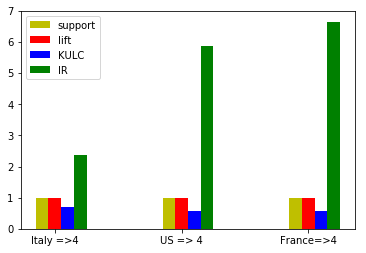

In [89]:
    name_list = ['Italy =>4', 'US => 4', 'France=>4']
    total_width, n = 0.4, 4
    width = total_width / n
    x = list(range(len(support)))
    plt.bar(x,support,width=width,label = "support",fc='y')
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, lift, width=width, label="lift",fc='r',tick_label=name_list)
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, KULC, width=width, label="KULC",fc='blue')
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, IR, width=width, label="IR",fc='g')
    plt.legend()
    plt.show()